#1. Non-stationarity and descriptive statistics of moment of returns


## Imports and Functions

In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
from scipy import stats
import scipy.stats as st
from datetime import date
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["font.size"] = 13

In [ ]:
! pip install wrds
import wrds
db = wrds.Connection(wrds_username='adamkeys')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Loading library list...
Done


In [ ]:
#db.get_table(library="tr_ds_comds",table="wrds_cmdy_data", obs=10)

# Urals.
urals = db.raw_sql(
    "SELECT * FROM tr_ds_comds.wrds_cmdy_data WHERE comcode = 12885"
)
urals = urals[["date_", "close_"]].drop_duplicates().set_index("date_").dropna()

# British Brent.
brent = db.raw_sql(
    "SELECT date_, close_ FROM tr_ds_comds.wrds_cmdy_data WHERE comcode = 2094"
).drop_duplicates().set_index("date_").dropna()

# WTI.
wti = db.raw_sql(
    "SELECT date_, close_ FROM tr_ds_comds.wrds_cmdy_data WHERE comcode = 847"
).drop_duplicates().set_index("date_").dropna()
wti.drop(wti[wti.index == date(2004,12,31)].index, inplace=True)

# Arabian murban.
murban = db.raw_sql(
    "SELECT date_, close_ FROM tr_ds_comds.wrds_cmdy_data WHERE comcode = 17532"
).dropna()
murban = murban.drop_duplicates().set_index("date_")

markets = [urals, brent, wti, murban]

urals = urals[urals.index < date(2023, 2, 1)]
wti = wti[wti.index < date(2023, 2, 1)]
brent = brent[brent.index < date(2023, 2, 1)]
murban = murban[murban.index < date(2023, 2, 1)]

In [ ]:
urals.index.min()

datetime.date(1998, 6, 8)

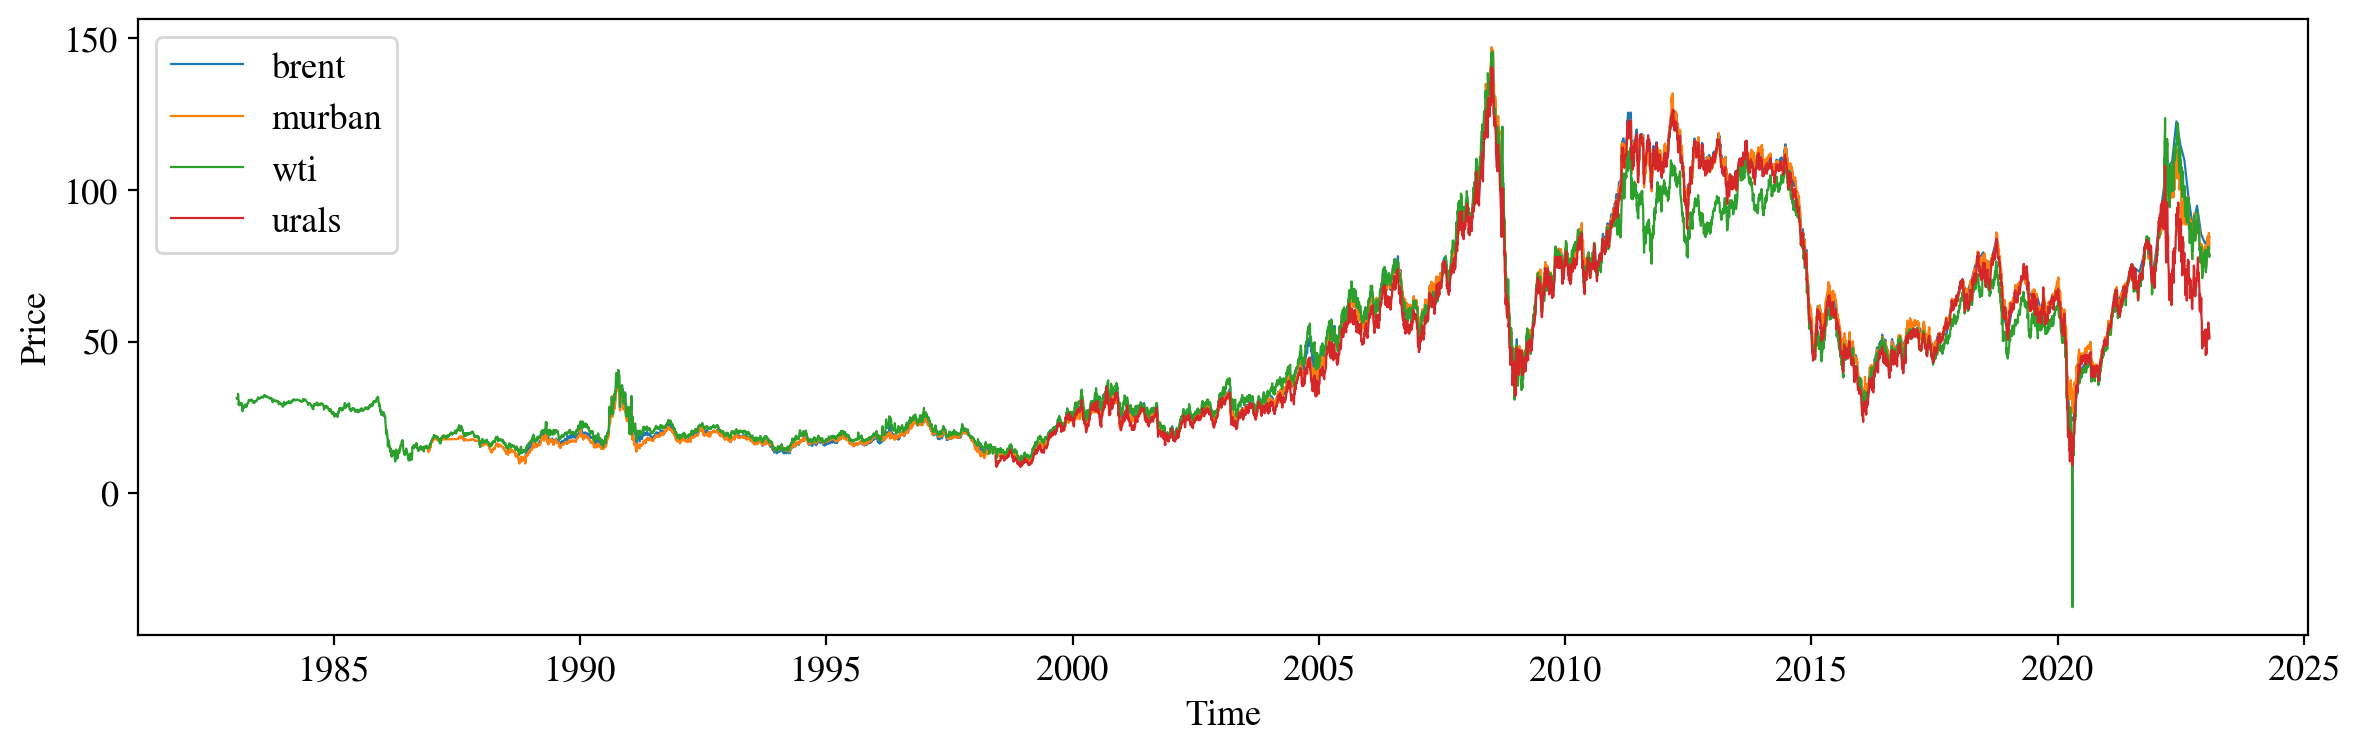

In [ ]:
linw = 0.8
plt.figure(figsize=(14,4), dpi=200)
plt.plot(brent, label="brent", linewidth=linw)
plt.plot(murban, label="murban", linewidth=linw)
plt.plot(wti, label="wti", linewidth=linw)
plt.plot(urals, label="urals", linewidth=linw)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.savefig("oil markets", dpi=450)

## Non-Stationarity & Moment Calculation

In [ ]:
#! pip install arch
import statsmodels.api as sm
from statsmodels.tsa.ar_model import ar_select_order
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("default")

In [ ]:
# Find P.

def lag_func(trend_val, data):
  mod = ar_select_order(data["close_"], maxlag=15, ic="bic", trend=trend_val)
  lags = []
  aic = []

  for key in mod.aic.keys():
    if key != 0:
      lags.append(len(key))
      aic.append(mod.bic[key])
    else:
      lags.append(0)
      aic.append(mod.bic[key])

  val_dict = {"c": "Constant", "n": "No Const.", "t": "Trend", "ct": "Const. + Trend"}

  df = pd.DataFrame(columns=["lags", "aic", "trend"])
  df["lags"] = lags
  df["aic"] = aic
  df["trend"] = val_dict[trend_val]
  df.drop(df[df["lags"] == 0].index, inplace=True)
  df["aicMinMax"] = (df["aic"] - df["aic"].mean())/(df["aic"].max() - df["aic"].min()) + 1

  return df

lag_murban = pd.concat([lag_func("c", murban), lag_func("n", murban), lag_func("ct", murban), lag_func("t", murban)])
lag_wti = pd.concat([lag_func("c", wti), lag_func("n", wti), lag_func("ct", wti), lag_func("t", wti)])
lag_urals = pd.concat([lag_func("c", urals), lag_func("n", urals), lag_func("ct", urals), lag_func("t", urals)])
lag_brent = pd.concat([lag_func("c", brent), lag_func("n", brent), lag_func("ct", brent), lag_func("t", brent)])

lag_dfs = [lag_murban, lag_wti, lag_urals, lag_brent]

0
1
2
3


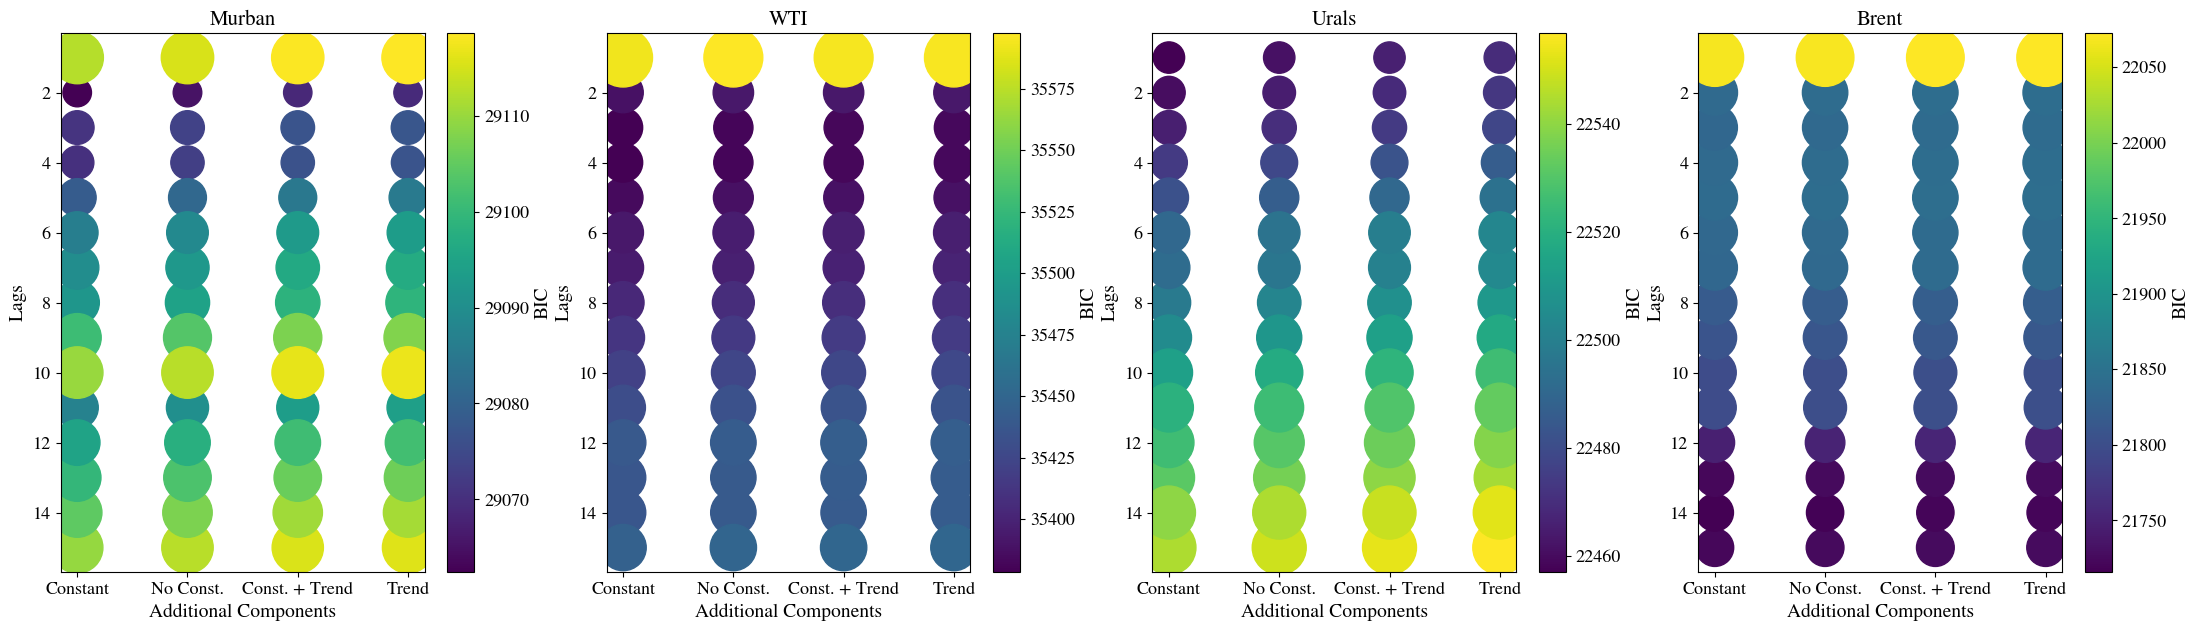

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(27, 7))
name_list = ["Murban", "WTI",  "Urals", "Brent"]

for i, df in enumerate(lag_dfs):
  print(i)
  # Generate some random data
  x = df["trend"].to_numpy()
  y = df["lags"].to_numpy()
  aic = df["aic"].to_numpy(dtype="float")
  aicMinMax = df["aicMinMax"].to_numpy(dtype="float")

  # Create the scatter plot
  sc = axes[i].scatter(x, y, c=aic, s=aicMinMax*1000, cmap='viridis')
  axes[i].invert_yaxis()

  # Add colorbar and adjust its properties
  cbar = plt.colorbar(sc)
  cbar.ax.set_ylabel('BIC', fontsize=14)

  # Set the labels for the x and y axis
  axes[i].set_xlabel('Additional Components', fontsize=14)
  axes[i].set_ylabel('Lags', fontsize=14)

  # Set the title for the plot
  axes[i].set_title(name_list[i], fontsize=15)

In [ ]:
! pip install arch

In [ ]:
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import kpss

# pp = PhillipsPerron(urals, lags=1, trend="c")
# print(pp.summary().as_text())

kpss(murban, regression="c", nlags=14)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(39.24477971209207,
 0.01,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [ ]:
# Split data in three.
n = 3
brent_1 = brent.iloc[:int(len(brent)*1/n)]
brent_2 = brent.iloc[int(len(brent)*1/n):int(len(brent)*2/n)]
brent_3 = brent.iloc[int(len(brent)*2/n):]

plt.hist(brent_1["Simple Rt"], alpha=0.7, bins=auto)
plt.hist(brent_2["Simple Rt"], alpha=0.7, bins=auto)
plt.hist(brent_3["Simple Rt"], alpha=0.7, bins=auot)

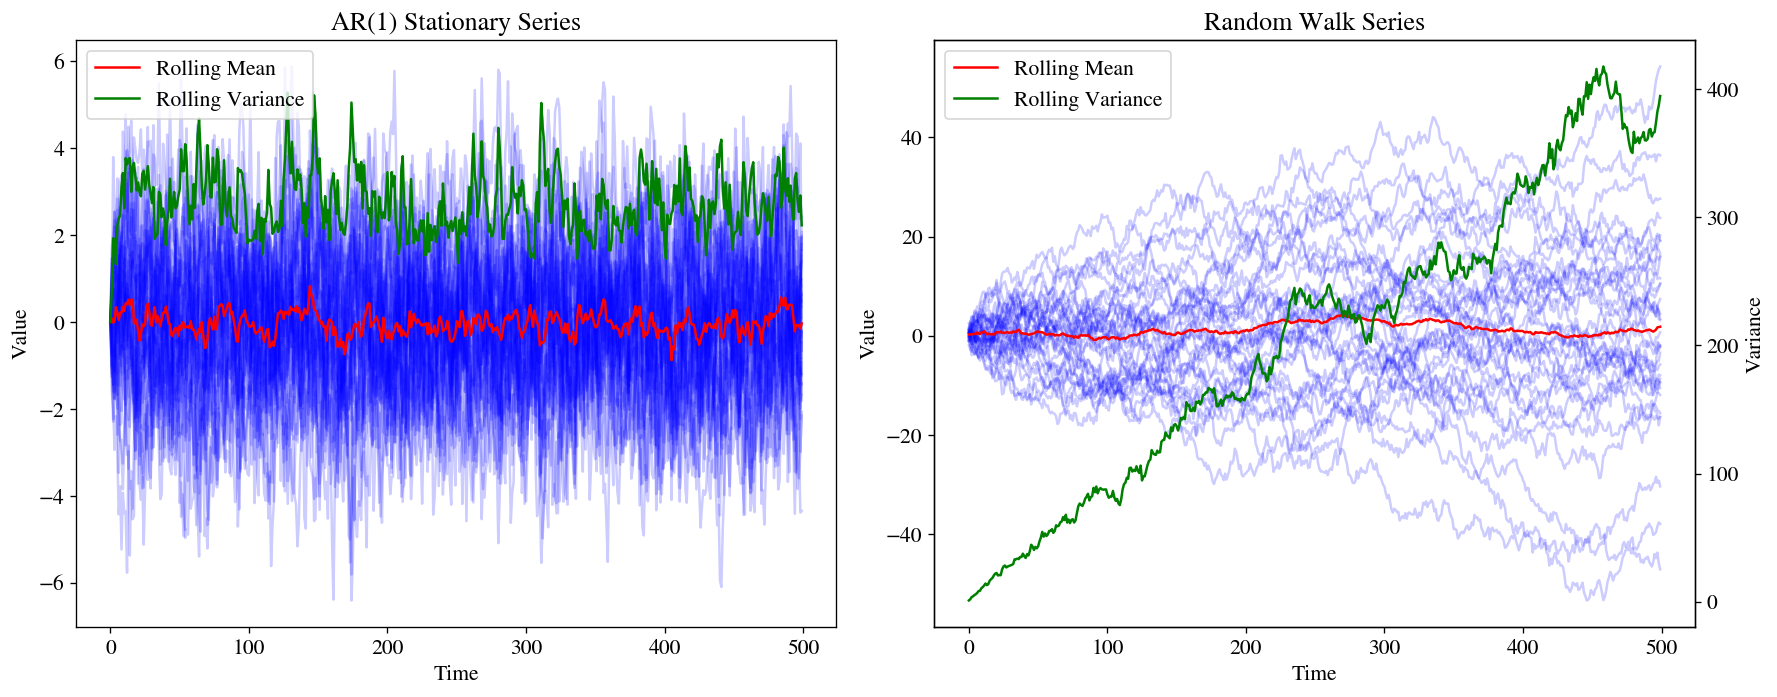

In [ ]:
 import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

def generate_ar_series(n, phi, noise_std):
    ar_series = np.zeros(n)
    noise = np.random.normal(0, noise_std, n)
    for i in range(1, n):
        ar_series[i] = phi * ar_series[i - 1] + noise[i]
    return ar_series

n = 500
phi = 0.8
noise_std = 1
n_series = 35

# Generate 40 random walks
random_walks = np.zeros((n_series, n))
for i in range(n_series):
    random_walks[i] = np.cumsum(np.random.normal(0, 1, n))

# Generate 40 AR(1) stationary time series
ar_series = np.zeros((n_series, n))
for i in range(n_series):
    ar_series[i] = generate_ar_series(n, phi, noise_std)

# Calculate the mean and variance of each series
random_walks_mean = np.mean(random_walks, axis=0)
random_walks_var = np.var(random_walks, axis=0)

ar_series_mean = np.mean(ar_series, axis=0)
ar_series_var = np.var(ar_series, axis=0)

# Plot the time series with average mean and variance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), dpi=120)

# AR(1) Stationary Series
for i in range(n_series):
    axes[0].plot(ar_series[i], alpha=0.2, color='blue')

axes[0].set_title("AR(1) Stationary Series")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].plot(ar_series_mean, color='red', label='Rolling Mean')
axes[0].plot(ar_series_var, color='green', label='Rolling Variance')

axes[0].legend(loc='upper left')

# Random Walk Series
for i in range(n_series):
    axes[1].plot(random_walks[i], alpha=0.2, color='blue')

axes[1].set_title("Random Walk Series")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")

ax_mean2 = axes[1]
ax_var2 = ax_mean2.twinx()

ax_mean2.plot(random_walks_mean, color='red', label='Rolling Mean')
ax_var2.plot(random_walks_var, color='green', label='Rolling Variance')

ax_var2.set_ylabel("Variance")

# Collect handles and labels from both axes
handles1, labels1 = ax_mean2.get_legend_handles_labels()
handles2, labels2 = ax_var2.get_legend_handles_labels()
axes[1].legend(handles1 + handles2, labels1 + labels2, loc='upper left')


plt.tight_layout()
plt.savefig("MCS Unit Root", dpi=400)
plt.show()

## Statistical Testing for Skew and Kurtosis

In [ ]:
wti["rt"] = wti["close_"].pct_change().dropna()
brent["rt"] = brent.pct_change().dropna()
urals["rt"] = urals.pct_change().dropna()
murban["rt"] = murban.pct_change().dropna()

In [ ]:
data = wti.dropna()
mean_data = data["rt"]
mean_CI = st.norm.interval(confidence=0.95, loc=np.mean(mean_data), scale=st.sem(mean_data))

skew = data["rt"].skew()
print(stats.skewtest(data["rt"].dropna()))

kurt = data["rt"].kurt()
print(st.kurtosistest(data["rt"].dropna()))

JB = stats.jarque_bera(data["rt"].dropna().values)
print(JB)

SkewtestResult(statistic=-153.657420363935, pvalue=0.0)
KurtosistestResult(statistic=75.81518673326447, pvalue=0.0)
SignificanceResult(statistic=3310288645.430997, pvalue=0.0)


In [ ]:
# Tests for normality.
#sm.qqplot(brent["Simple Rt"], line ='45')

stat, p = st.normaltest(urals["rt"].dropna())
alpha = 0.05
if p > alpha:
 print('Sample looks Gaussian (fail to reject H0), p =', p)
else:
 print('Sample does not look Gaussian (reject H0), p =', p)

Sample does not look Gaussian (reject H0), p = 0.0


### Bootstrapping Method

In [ ]:
data = wti["rt"]
data = data.values.reshape(1, len(data))

def bootstrap(data, n=40_000):
  ## –––––––––––––––––––––––––––––––––––––– Variance –––––––––––––––––––––––––––––––––––––– ##
  def variance(data):
      return np.var(data)

  boot_var = stats.bootstrap(data, variance, n_resamples=n)

  lower, upper = np.percentile(boot_var.bootstrap_distribution, [2.5, 97.5])

  print("Estimated variance: {:.6f}".format(np.var(data)))
  print("95% confidence interval: ({:.6f}, {:.6f})".format(lower, upper))


  ## –––––––––––––––––––––––––––––––––––––– Skewness –––––––––––––––––––––––––––––––––––––– ##
  def skewness(data):
      return st.skew(data.T)

  boot_skew = stats.bootstrap(data, skewness, n_resamples=n)

  lower, upper = np.percentile(boot_skew.bootstrap_distribution, [2.5, 97.5])

  print(f"Estimated skewness: {round(st.skew(data.T)[0])}")
  print("95% confidence interval: ({:.3f}, {:.3f})".format(lower, upper))

  ## –––––––––––––––––––––––––––––––––––––– Kurtosis –––––––––––––––––––––––––––––––––––––– ##

  def kurtosis(data):
      return st.kurtosis(data.T)

  boot_kurt = stats.bootstrap(data, kurtosis, n_resamples=n)

  lower, upper = np.percentile(boot_kurt.bootstrap_distribution, [2.5, 97.5])

  print(f"Estimated kurtosis: {round(st.kurtosis(data.T)[0], 4)}")
  print("95% confidence interval: ({:.3f}, {:.3f})".format(lower, upper))

  return boot_var, boot_skew, boot_kurt

In [ ]:
data = wti["rt"].dropna()
data.drop(data.idxmin(), inplace=True)
data.drop(data.idxmin(), inplace=True)
data = data.values.reshape(1, len(data))

wti_var, wti_skew, wti_kurt = bootstrap(data)
data = brent["rt"].dropna()
data = data.values.reshape(1, len(data))
brent_var, brent_skew, brent_kurt = bootstrap(data)

data = murban["rt"].dropna()
data = data.values.reshape(1, len(data))
murban_var, murban_skew, murban_kurt = bootstrap(data)

data = urals["rt"].dropna()
data = data.values.reshape(1, len(data))
urals_var, urals_skew, urals_kurt = bootstrap(data)

Estimated variance: 0.000702
95% confidence interval: (0.000639, 0.000772)
Estimated skewness: 0
95% confidence interval: (-0.433, 1.387)
Estimated kurtosis: 21.512
95% confidence interval: (14.084, 28.252)
Estimated variance: 0.000499
95% confidence interval: (0.000413, 0.000615)
Estimated skewness: -1
95% confidence interval: (-5.114, 2.373)
Estimated kurtosis: 77.1924
95% confidence interval: (12.791, 139.839)
Estimated variance: 0.000509
95% confidence interval: (0.000478, 0.000543)
Estimated skewness: 0
95% confidence interval: (-0.703, 0.189)
Estimated kurtosis: 8.4671
95% confidence interval: (5.304, 12.252)
Estimated variance: 0.000820
95% confidence interval: (0.000722, 0.000935)
Estimated skewness: 0
95% confidence interval: (-1.378, 1.424)
Estimated kurtosis: 25.426
95% confidence interval: (12.325, 37.504)


In [ ]:
for i in temp:
  for j in i:
    print(np.median(j.bootstrap_distribution))

0.0007006674526933486
0.0004925089472372125
0.0005083600642994469
0.0008165517377941838
0.48640736122604955
-0.9317983203341071
-0.2381233508151734
0.0984469449300604
21.200287849317977
72.95868556856121
8.224094838375638
24.54919129617085


Text(0.5, 1.0, 'Urals')

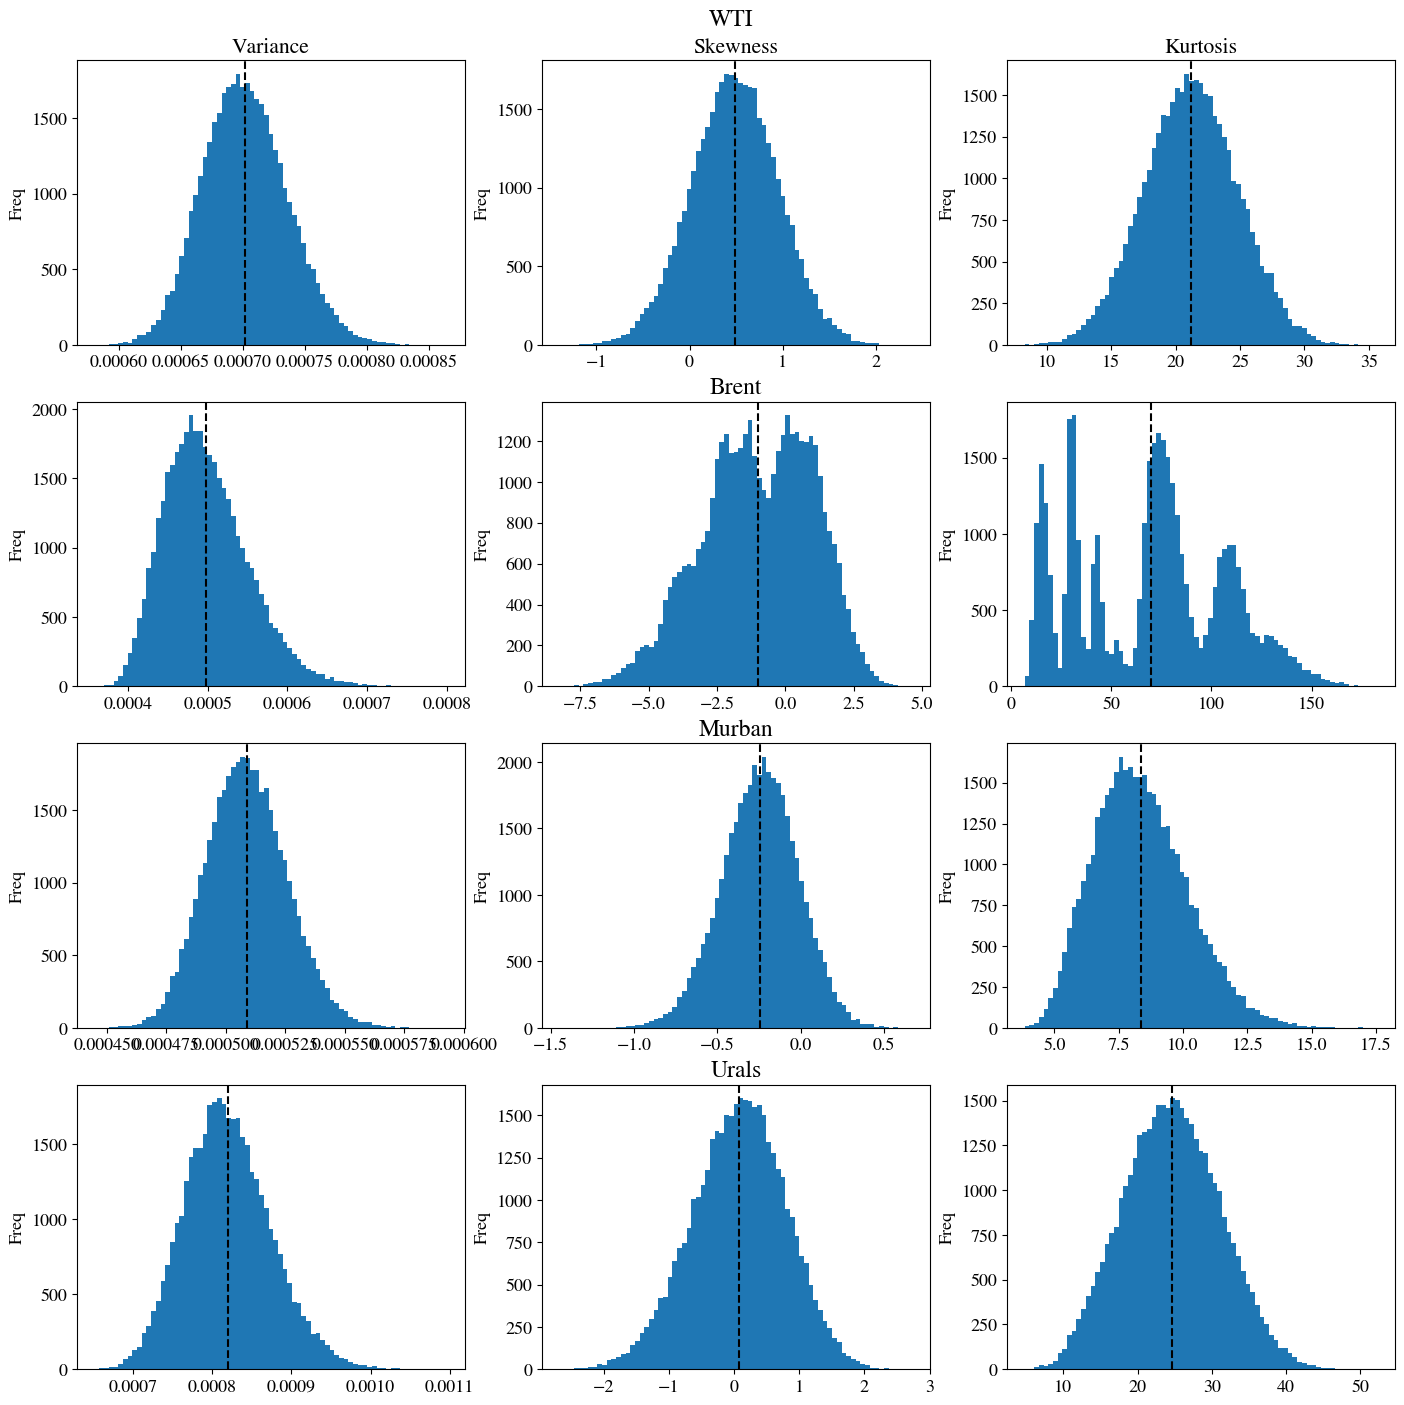

In [ ]:
temp = [[wti_var, brent_var, murban_var, urals_var], [wti_skew, brent_skew, murban_skew, urals_skew], [wti_kurt, brent_kurt, murban_kurt, urals_kurt]]
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(17,  17))
temp_dict = {0: "Variance", 1: "Skewness", 2: "Kurtosis"}

for i, item in enumerate(temp):
  axes[0,i].hist(item[0].bootstrap_distribution, bins=75)
  axes[0,i].axvline(item[0].bootstrap_distribution.mean(), color="black", linestyle="dashed")
  #axes[0,i].set_xlabel(temp_dict[i])
  axes[0,i].set_ylabel("Freq")

  axes[1,i].hist(item[1].bootstrap_distribution, bins=75)
  axes[1,i].axvline(item[1].bootstrap_distribution.mean(), color="black", linestyle="dashed")
  #axes[1,i].set_xlabel(temp_dict[i])
  axes[1,i].set_ylabel("Freq")

  axes[2,i].hist(item[2].bootstrap_distribution, bins=75)
  axes[2,i].axvline(item[2].bootstrap_distribution.mean(), color="black", linestyle="dashed")
  #axes[2,i].set_xlabel(temp_dict[i])
  axes[2,i].set_ylabel("Freq")

  axes[3,i].hist(item[3].bootstrap_distribution, bins=75)
  axes[3,i].axvline(item[3].bootstrap_distribution.mean(), color="black", linestyle="dashed")
  #axes[3,i].set_xlabel(temp_dict[i])
  axes[3,i].set_ylabel("Freq")

axes[0,0].set_title("Variance")
axes[0,1].set_title("Skewness")
axes[0,2].set_title("Kurtosis")

fig.suptitle("WTI",  x=0.51, y=0.91, fontsize=17)
axes[1,1].set_title("Brent", fontsize=17)
axes[2,1].set_title("Murban", fontsize=17)
axes[3,1].set_title("Urals", fontsize=17)

In [ ]:
fig.savefig("boot_hists", dpi=740)

In [ ]:
returns = brent[(brent["rt"] > -0.15) & (brent["rt"] < 0.15)]
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13,10))

## ADD GUASSIAN USING GPT
axes[0,0].axvline(wti["rt"].mean(), color="black", linestyle="dashed")
axes[0,0].hist(wti["rt"], bins=170, alpha=0.9)
axes[0,0].set_xlim([-0.2,0.2])
axes[0,0].set_ylabel("Freq")
axes[0,0].set_xlabel("Returns")
axes[0,0].set_title("WTI")

axes[0,1].axvline(brent["rt"].mean(), color="black", linestyle="dashed")
axes[0,1].hist(brent["rt"], bins=75, alpha=0.9)
axes[0,1].set_xlim([-0.2,0.2])
axes[0,1].set_ylabel("Freq")
axes[0,1].set_xlabel("Returns")
axes[0,1].set_title("Brent")

axes[1,0].axvline(murban["rt"].mean(), color="black", linestyle="dashed")
axes[1,0].hist(murban["rt"], bins=75, alpha=0.9)
axes[1,0].set_xlim([-0.2,0.2])
axes[1,0].set_ylabel("Freq")
axes[1,0].set_xlabel("Returns")
axes[1,0].set_title("Murban")

axes[1,1].axvline(urals["rt"].mean(), color="black", linestyle="dashed")
axes[1,1].hist(urals["rt"], bins=75, alpha=0.9)
axes[1,1].set_xlim([-0.2,0.2])
axes[1,1].set_ylabel("Freq")
axes[1,1].set_xlabel("Returns")
axes[1,1].set_title("Urals")

#fig.savefig("Returns hists", dpi=600)

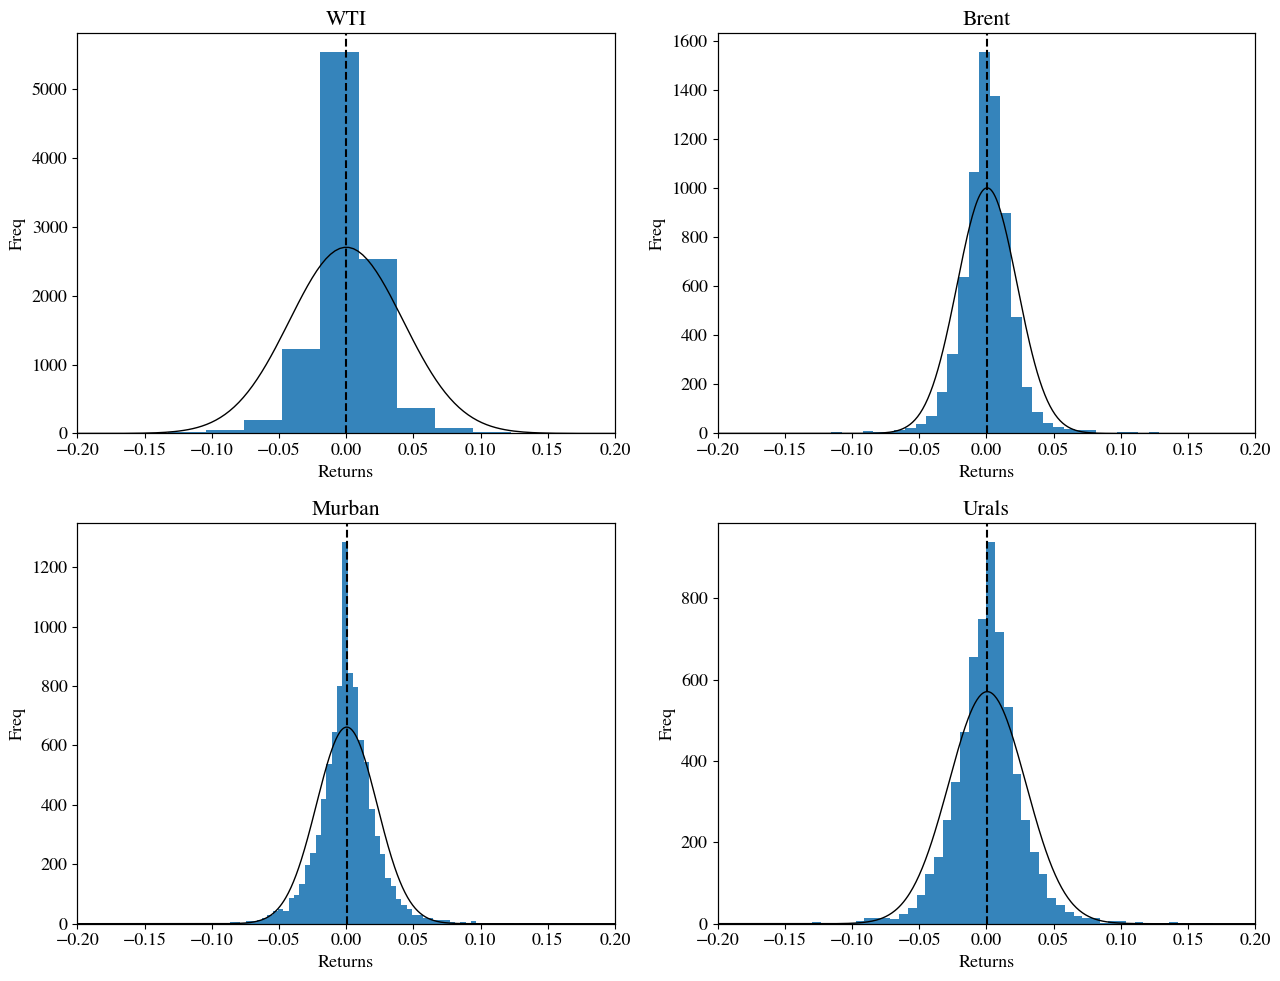

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming wti, brent, murban, and urals data are already loaded

# Define a function to plot Gaussian distribution
def plot_gaussian(ax, data, bins, bin_width, color='black'):
    mu, sigma = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), bins)
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    y_scaled = y * bin_width * len(data) # Scale y-values to match true frequency
    ax.plot(x, y_scaled, color=color, linewidth=1)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13, 10))

datasets = [wti, brent, murban, urals]
titles = ["WTI", "Brent", "Murban", "Urals"]

for i in range(2):
    for j in range(2):
        data = datasets[i * 2 + j]["rt"]
        ax = axes[i, j]
        ax.axvline(data.mean(), color="black", linestyle="dashed")
        n_bins = 120
        bin_width = (data.max() - data.min()) / n_bins
        ax.hist(data, bins=n_bins, alpha=0.9, density=False)
        ax.set_xlim([-0.2, 0.2])
        ax.set_ylabel("Freq")
        ax.set_xlabel("Returns")
        ax.set_title(titles[i * 2 + j])

        # Plot Gaussian distribution on twin axes
        ax_gaussian = ax.twinx()
        plot_gaussian(ax_gaussian, data, 1000, bin_width)
        ax_gaussian.set_ylim([0, ax.get_ylim()[1]])
        ax_gaussian.set_yticks([]) # Remove y-axis ticks from Gaussian plot

plt.tight_layout()
fig.savefig("returns_hists", dpi=600)


#2. Taking the Spread and Model Estimation


In [ ]:
! pip install pmdarima
from pmdarima.arima import auto_arima

In [ ]:
brent/wti
brent/urals
brent/murban
murban/wti
murban/urals
wti/urals

In [ ]:
brentwti = brent - wti
brentwti.dropna(inplace=True)

brenturals = brent - urals
brenturals.dropna(inplace=True)

brentmurban = brent - murban
brentmurban.dropna(inplace=True)

murbanwti = murban - wti
murbanwti.dropna(inplace=True)

murbanurals = murban - urals
murbanurals.dropna(inplace=True)

wtiurals = wti - urals
wtiurals.dropna(inplace=True)

coint = [brentwti, brenturals, brentmurban, murbanwti, murbanurals, wtiurals]

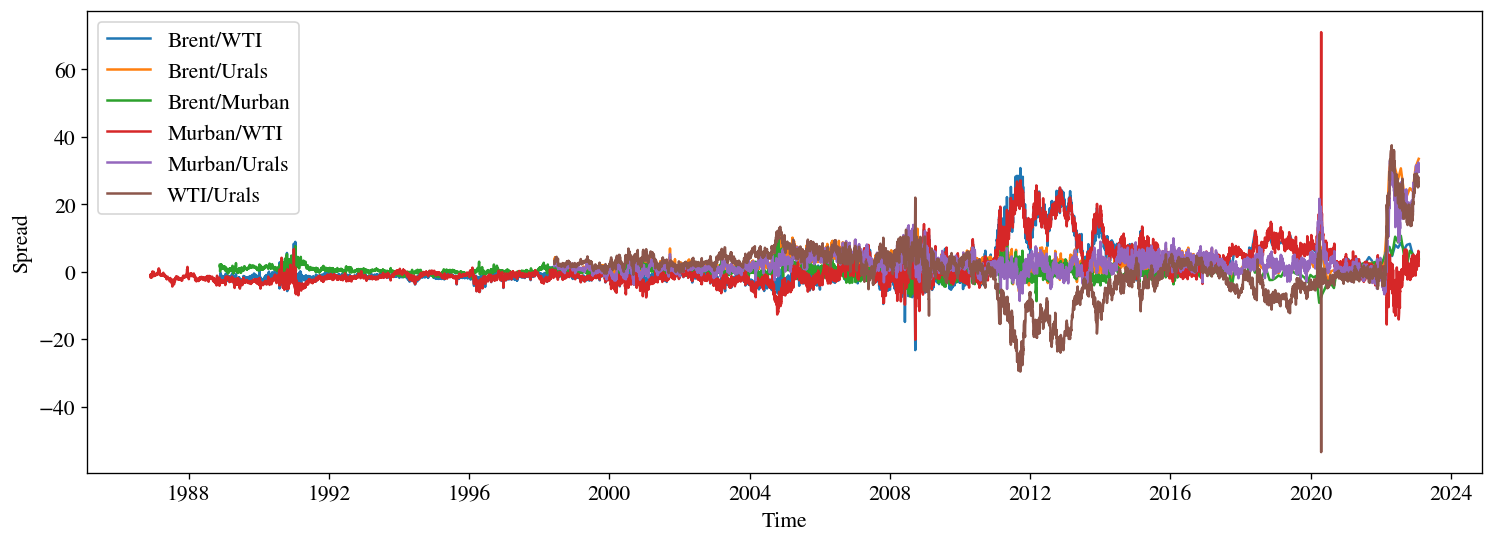

In [ ]:
plt.figure(figsize=(15,5), dpi=120)
for i in coint:
  plt.plot(i)

plt.legend(["Brent/WTI", "Brent/Urals", "Brent/Murban", "Murban/WTI", "Murban/Urals", "WTI/Urals"])
plt.xlabel("Time")
plt.ylabel("Spread")
plt.savefig("spreads", dpi=520)

In [ ]:
for i in coint:
  print("––––––––––––––––– \n")
  auto_arima(i, stepwise=True, trace=True, start_p=1, max_p=10, start_q=1, max_q=10, information_criterion="bic")

In [ ]:
! pip install arch

In [ ]:
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import kpss, adfuller
lagS = [12, 7, 9, 13, 6, 6]

# for i, v in zip(coint, lagS):
#   pp = PhillipsPerron(i, lags=v, trend="c")
#   print(pp.summary().as_text())

# for i, v in zip(coint, lagS):
#   print(kpss(i, regression="c", nlags=v))

for i, v in zip(coint, lagS):
  print(adfuller(i, regression="c"))

(-3.137720265569807, 0.02388475725274757, 20, 6921, {'1%': -3.4312951996865126, '5%': -2.861957701574514, '10%': -2.5669923386600497}, 24102.024711949038)
(-4.491725688820105, 0.00020352134905209432, 8, 4685, {'1%': -3.431746560628211, '5%': -2.8621571196498476, '10%': -2.567098495106319}, 16820.126381178525)
(-7.766520899134979, 9.15708779198317e-12, 27, 7067, {'1%': -3.4312756653255705, '5%': -2.8619490703161747, '10%': -2.566987744089607}, 18995.86893153964)
(-3.47931017570887, 0.008534625824934255, 37, 9046, {'1%': -3.431073099336447, '5%': -2.8618595631816808, '10%': -2.566940098443952}, 33010.93300930799)
(-3.6783909900777463, 0.004427577711977345, 8, 6288, {'1%': -3.431390389875675, '5%': -2.8619997605532332, '10%': -2.5670147275324298}, 21575.53708432323)
(-2.487832994296543, 0.11846282451510015, 19, 6113, {'1%': -3.4314201861732214, '5%': -2.862012925518365, '10%': -2.5670217355656004}, 21903.307905298916)


In [ ]:
from statsmodels.tsa.ar_model import ar_select_order

def lag_func2(trend_val, data):
  mod = ar_select_order(data, maxlag=15, ic="bic", trend=trend_val)
  lags = []
  aic = []

  for key in mod.aic.keys():
    if key != 0:
      lags.append(len(key))
      aic.append(mod.bic[key])
    else:
      lags.append(0)
      aic.append(mod.bic[key])

  val_dict = {"c": "Constant", "n": "No Const.", "t": "Trend", "ct": "Const. + Trend"}

  df = pd.DataFrame(columns=["lags", "aic", "trend"])
  df["lags"] = lags
  df["aic"] = aic
  df["trend"] = val_dict[trend_val]
  df.drop(df[df["lags"] == 0].index, inplace=True)
  df["aicMinMax"] = (df["aic"] - df["aic"].mean())/(df["aic"].max() - df["aic"].min()) + 1

  return df

In [ ]:
trend_vals = ["c", "n", "t", "ct"]
data = []

for i in coint:
    data.append(pd.concat([lag_func2("c", i), lag_func2("n", i), lag_func2("ct", i), lag_func2("t", i)]))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(wtiurals, order=(1, 0, 2), trend="n")
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 close_   No. Observations:                 6133
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -11014.605
Date:                Tue, 25 Apr 2023   AIC                          22037.211
Time:                        20:59:30   BIC                          22064.097
Sample:                             0   HQIC                         22046.537
                               - 6133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9972      0.001   1084.507      0.000       0.995       0.999
ma.L1         -0.4744      0.002   -301.200      0.000      -0.477      -0.471
ma.L2         -0.0566      0.003    -16.766      0.0

In [ ]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
oils = [[brent, wti], [brent, urals], [brent, murban], [murban, wti], [murban, urals], [wti, urals]]
temp = [brentwti, brenturals, brentmurban, murbanwti, murbanurals, wtiurals]

#mod = OLS(brent.loc[brentwti.index], wti.loc[brentwti.index])
#res = mod.fit()
#adfuller(res.resid, regression="n")

for i, z in zip(oils, temp):
  print(coint(i[0].loc[z.index], i[1].loc[z.index]))

(-4.427272764085882, 0.0016085701523021777, array([-3.89801855, -3.33701043, -3.04506109]))
(-4.511384256921878, 0.0011729591940577882, array([-3.89877519, -3.33743227, -3.04535385]))
(-7.853099710233239, 7.050059455485255e-11, array([-3.89798449, -3.33699144, -3.04504791]))
(-4.638271727703874, 0.0007192320752637521, array([-3.89764616, -3.33680278, -3.04491697]))
(-3.731467449101787, 0.016686565642419857, array([-3.89818035, -3.33710065, -3.0451237 ]))
(-2.6274037926715383, 0.22676686071798313, array([-3.89822692, -3.33712661, -3.04514172]))


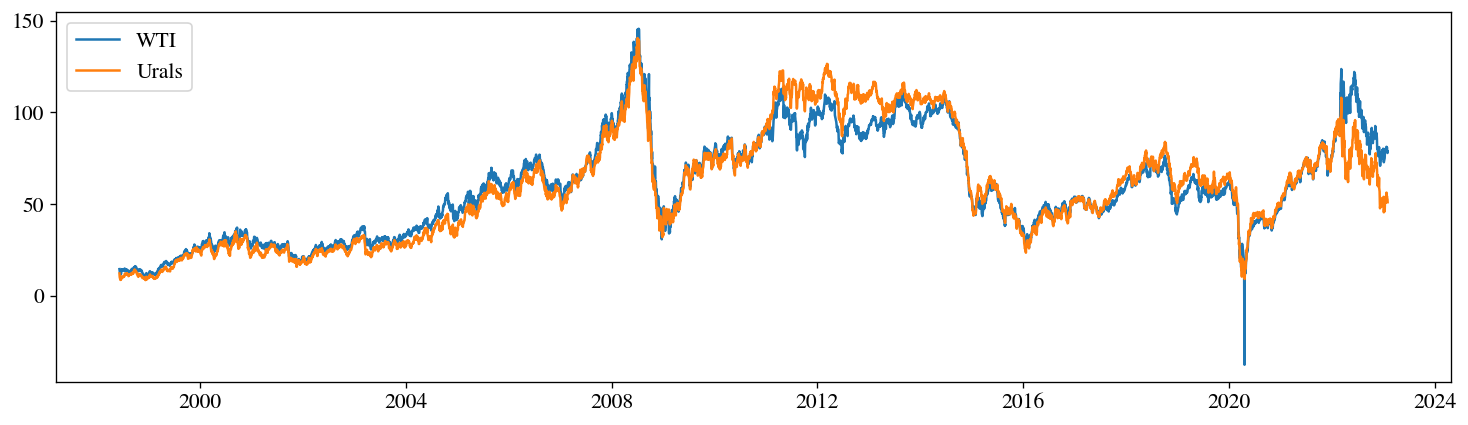

In [ ]:
plt.figure(figsize=(15,4), dpi=120)
plt.plot(wti.loc[wtiurals.index], label="WTI")

plt.plot(urals, label="Urals")
plt.legend()
plt.savefig("WTI URALS", dpi=600)

# 4. Cointegration Testing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
from itertools import combinations
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [ ]:
brent2 = brent[brent.index > date(2022, 2, 1)]
brent2 = brent2[brent2.index < date(2023, 1, 1)]
wti2 = wti[wti.index > date(2022, 2, 1)]
wti2 = wti2[wti2.index < date(2023, 1, 1)]
murban2 = murban[murban.index > date(2022, 2, 1)]
murban2 = murban2[murban2.index < date(2023, 1, 1)]
urals2 = urals[urals.index > date(2022, 2, 1)]
urals2 = urals2[urals2.index < date(2023, 1, 1)]

In [ ]:
brent2 = yf.download("BZ=F", start="2022-2-1", end="2022-12-31")["Adj Close"]
brent2 = brent2.dropna()
brent2 = brent2.drop_duplicates()

[*********************100%***********************]  1 of 1 completed


In [ ]:
brent2.index = wti2.index[0:len(brent2)]

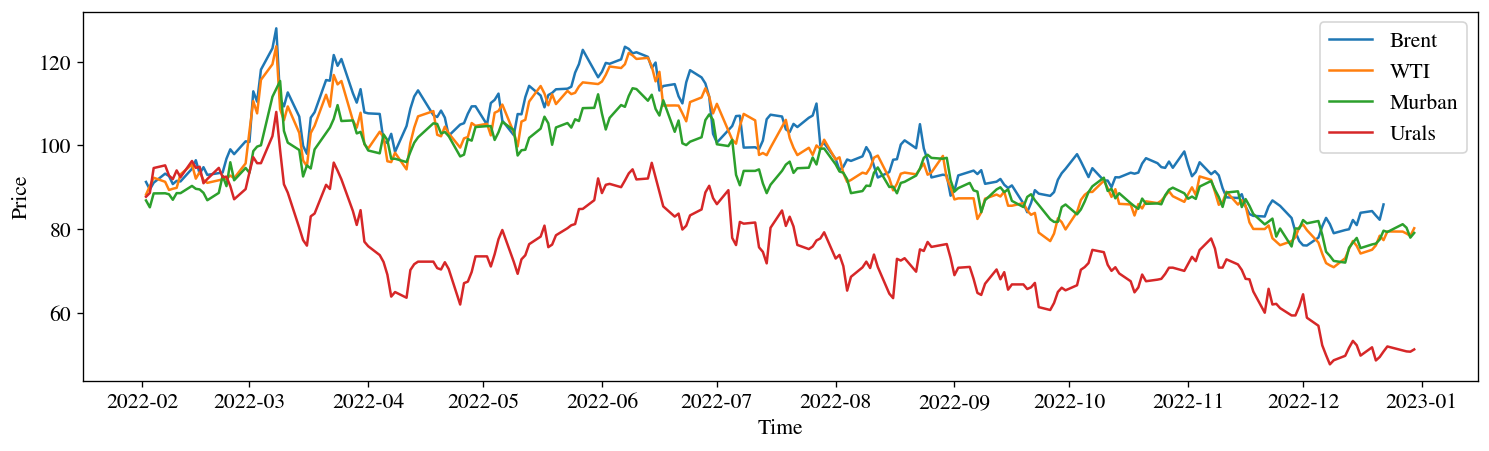

In [ ]:
plt.figure(figsize=(15,4), dpi=120)
plt.plot(brent2, label="Brent")
plt.plot(wti2, label="WTI")
plt.plot(murban2, label="Murban")
plt.plot(urals2, label="Urals")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.savefig("ukraine time series", dpi=300)

In [ ]:
tickers = ["brent", "wti", "urals", "murban"]
tickers_dict = {"brent": brent, "wti": wti, "urals": urals, "murban": murban}
n_2, n_3, n_4 = list(combinations(tickers, 2)), list(combinations(tickers, 3)), list(combinations(tickers, 4))

tickers_comb = n_2 + n_3 + n_4
len(tickers_comb), len(n_2)

(11, 6)

In [ ]:
tickers_comb2 = []
for i in tickers_comb:
    tickers_comb2.append(list(i))

In [ ]:
coint_tickers = []
for firms in tickers_comb2:
    data = pd.DataFrame()
    for market in firms:
      data = pd.concat([data.dropna(), tickers_dict[market]], axis=1)
    data.dropna(inplace=True)
    print(len(data))
    try:
      jres = coint_johansen(data, det_order=0, k_ar_diff=1)
    except:
      print(firms)
    Y = 0
    for i in range(len(jres.trace_stat)):
        if jres.trace_stat[i] > jres.trace_stat_crit_vals[i, 2]:
            Y = Y + 1
        else:
            break

    coint_tickers.append([firms, Y])

6942
4694
7095
6133
9084
6297
4587
6933
4687
6124
4581


In [ ]:
jres.trace_stat

array([664.20758467, 309.08386275,  25.21875655,   3.99582335])

In [ ]:
jres.trace_stat_crit_vals

array([[44.4929, 47.8545, 54.6815],
       [27.0669, 29.7961, 35.4628],
       [13.4294, 15.4943, 19.9349],
       [ 2.7055,  3.8415,  6.6349]])

In [ ]:
coint_tickers

[[['brent', 'wti'], 1],
 [['brent', 'urals'], 1],
 [['brent', 'murban'], 1],
 [['wti', 'urals'], 1],
 [['wti', 'murban'], 1],
 [['urals', 'murban'], 1],
 [['brent', 'wti', 'urals'], 2],
 [['brent', 'wti', 'murban'], 2],
 [['brent', 'urals', 'murban'], 2],
 [['wti', 'urals', 'murban'], 2],
 [['brent', 'wti', 'urals', 'murban'], 3]]

In [ ]:
! pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


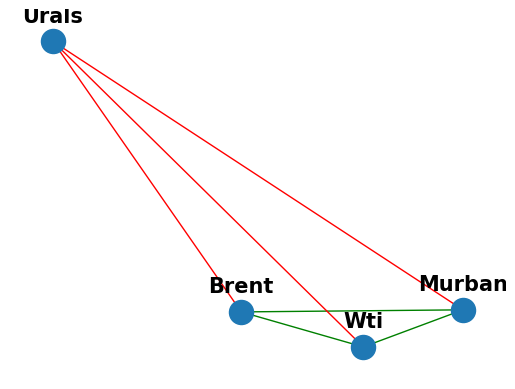

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

data= [[['brent', 'wti'], 1],
 [['brent', 'urals'], 1],
 [['brent', 'murban'], 1],
 [['wti', 'urals'], 1],
 [['wti', 'murban'], 1],
 [['urals', 'murban'], 1],
 [['brent', 'wti', 'urals'], 2],

G = nx.Graph()

for item in data:
    n = len(item[0])
    for i in range(n - 1):
        G.add_edge(item[0][i].capitalize(), item[0][i + 1].capitalize(), weight=item[1], color="red" if item[1] == 0 else ("green" if item[1] == n - 1 else "blue"))

pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos)

# Draw node labels
labels_pos = {k: [v[0], v[1] + 0.12] for k, v in pos.items()}  # Shift labels up by 0.1 units
nx.draw_networkx_labels(G, labels_pos, font_size=15, font_weight="bold")

# Draw edges
edges = G.edges(data=True)
colors = [d["color"] for _, _, d in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors)

plt.axis("off")
plt.savefig("coint network", dpi=500)

In [ ]:
! pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


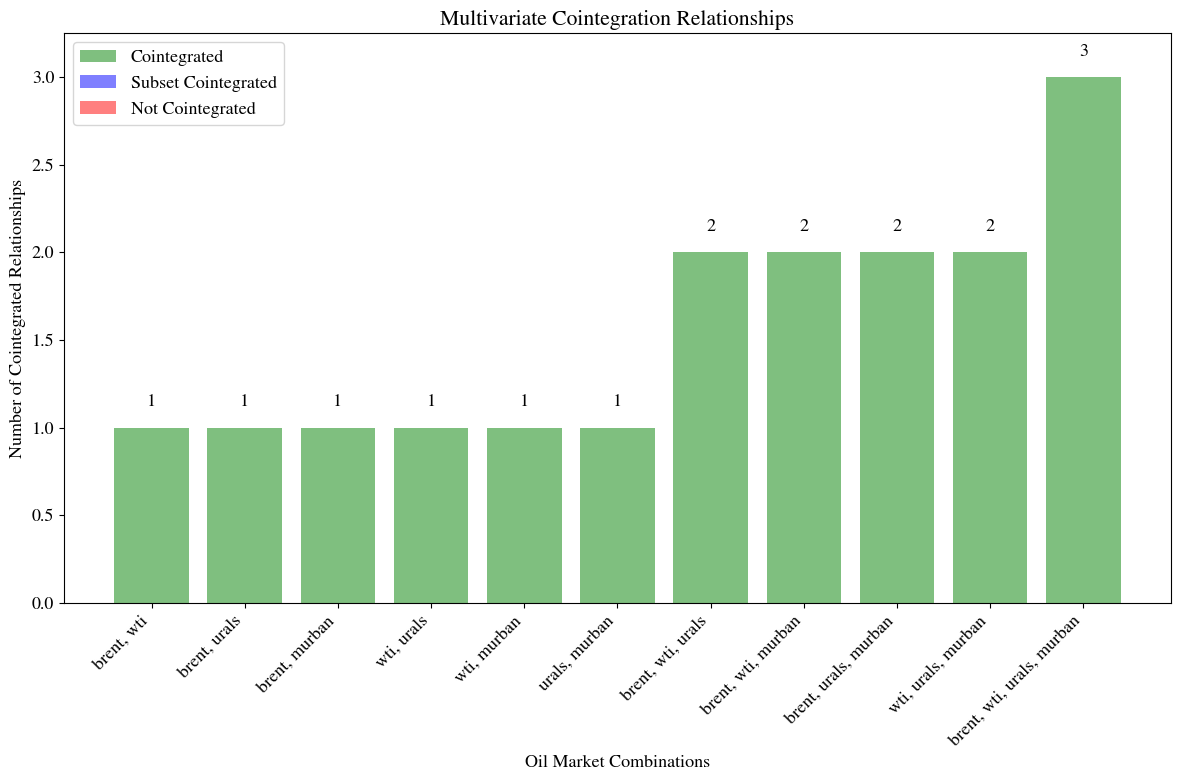

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = [[['brent', 'wti'], 1],
 [['brent', 'urals'], 1],
 [['brent', 'murban'], 1],
 [['wti', 'urals'], 1],
 [['wti', 'murban'], 1],
 [['urals', 'murban'], 1],
 [['brent', 'wti', 'urals'], 2],
 [['brent', 'wti', 'murban'], 2],
 [['brent', 'urals', 'murban'], 2],
 [['wti', 'urals', 'murban'], 2],
 [['brent', 'wti', 'urals', 'murban'], 3]]


df = pd.DataFrame(data, columns=['combination', 'cointegrated_count'])
df['combination'] = df['combination'].apply(lambda x: ', '.join(x))
df['color'] = df.apply(lambda x: 'green' if x['cointegrated_count'] == len(eval(x['combination'])) - 1 else ('blue' if x['cointegrated_count'] > 0 else 'red'), axis=1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(df['combination'], df['cointegrated_count'], color=df['color'], alpha=0.5)

for i, row in df.iterrows():
    ax.text(row['combination'], row['cointegrated_count']+0.1, row['cointegrated_count'], ha='center', va='bottom')

ax.set_xlabel('Oil Market Combinations')
ax.set_ylabel('Number of Cointegrated Relationships')
ax.set_title('Multivariate Cointegration Relationships')

# Add legend
green_patch = plt.Rectangle((0,0),1,1,fc='green', alpha=0.5, label='Cointegrated')
blue_patch = plt.Rectangle((0,0),1,1,fc='blue', alpha=0.5, label='Subset Cointegrated')
red_patch = plt.Rectangle((0,0),1,1,fc='red', alpha=0.5, label='Not Cointegrated')
ax.legend(handles=[green_patch, blue_patch, red_patch], loc='upper left')

plt.xticks(rotation=45, ha='right')
plt.ylim([0,3.25])
plt.tight_layout() # adjust spacing between subplots and axis labels
plt.savefig("mutivariate coint", dpi=500)
plt.show()


In [ ]:
coint_tickers = []
for firms in tickers_comb2:
    data = pd.DataFrame()
    for market in firms:
      data = pd.concat([data, tickers_dict[market]], axis=1)
    data.dropna(inplace=True)

    data = data[data.index < date(2022, 2, 24)]
    jres = coint_johansen(data, det_order=0, k_ar_diff=1)
    X = 0
    for i in range(len(jres.trace_stat)):
        #print(firms, jres.trace_stat[i], jres.trace_stat_crit_vals[i, 2])
        if jres.trace_stat[i] > jres.trace_stat_crit_vals[i, 1]:
            X = X + 1
        else:
            break

    coint_tickers.append([firms, X])

In [ ]:
import yfinance as yf
tickers = ["XOM", "CVX", "SHEL", "PTR", "COP", "EQNR", "BP", "PBR", "ENB", "PBR-A", "SNP", "EOG", "OXY", "CNQ", "PXD", "EPD", "SLB", "TRP", "VLO", "DVN", "SU", "WDS"]
data = yf.download(tickers, start="2010-01-01", end="2022-01-01")
data = data["Adj Close"]

[*********************100%***********************]  22 of 22 completed

2 Failed downloads:
- PTR: No timezone found, symbol may be delisted
- SNP: No timezone found, symbol may be delisted


In [ ]:
n_2, n_3, n_4 = list(combinations(tickers, 2)), list(combinations(tickers, 3)), list(combinations(tickers, 4))
tickers_comb = n_2 + n_3 + n_4
len(tickers_comb), len(n_2)
tickers_comb2 = []
for i in tickers_comb:
    tickers_comb2.append(list(i))

In [ ]:
coint_tickers = []
for firms in tickers_comb2:
    temp_data = data[firms].dropna()
    if len(temp_data) > 10 and len(firms) == 2:
      jres = coint_johansen(data[firms].dropna(), det_order=1, k_ar_diff=1)
    else:
      pass
    X = 0
    for i in range(len(jres.trace_stat)):
        #print(firms, jres.trace_stat[i], jres.trace_stat_crit_vals[i, 2])
        if jres.trace_stat[i] > jres.trace_stat_crit_vals[i, 2]:
            X = X + 1
        else:
            break

    coint_tickers.append([firms, X])

coint_tickers2 = []

for i in coint_tickers:
  if len(i[0]) == 2:
    coint_tickers2.append(i)


In [ ]:
coint_tickers2

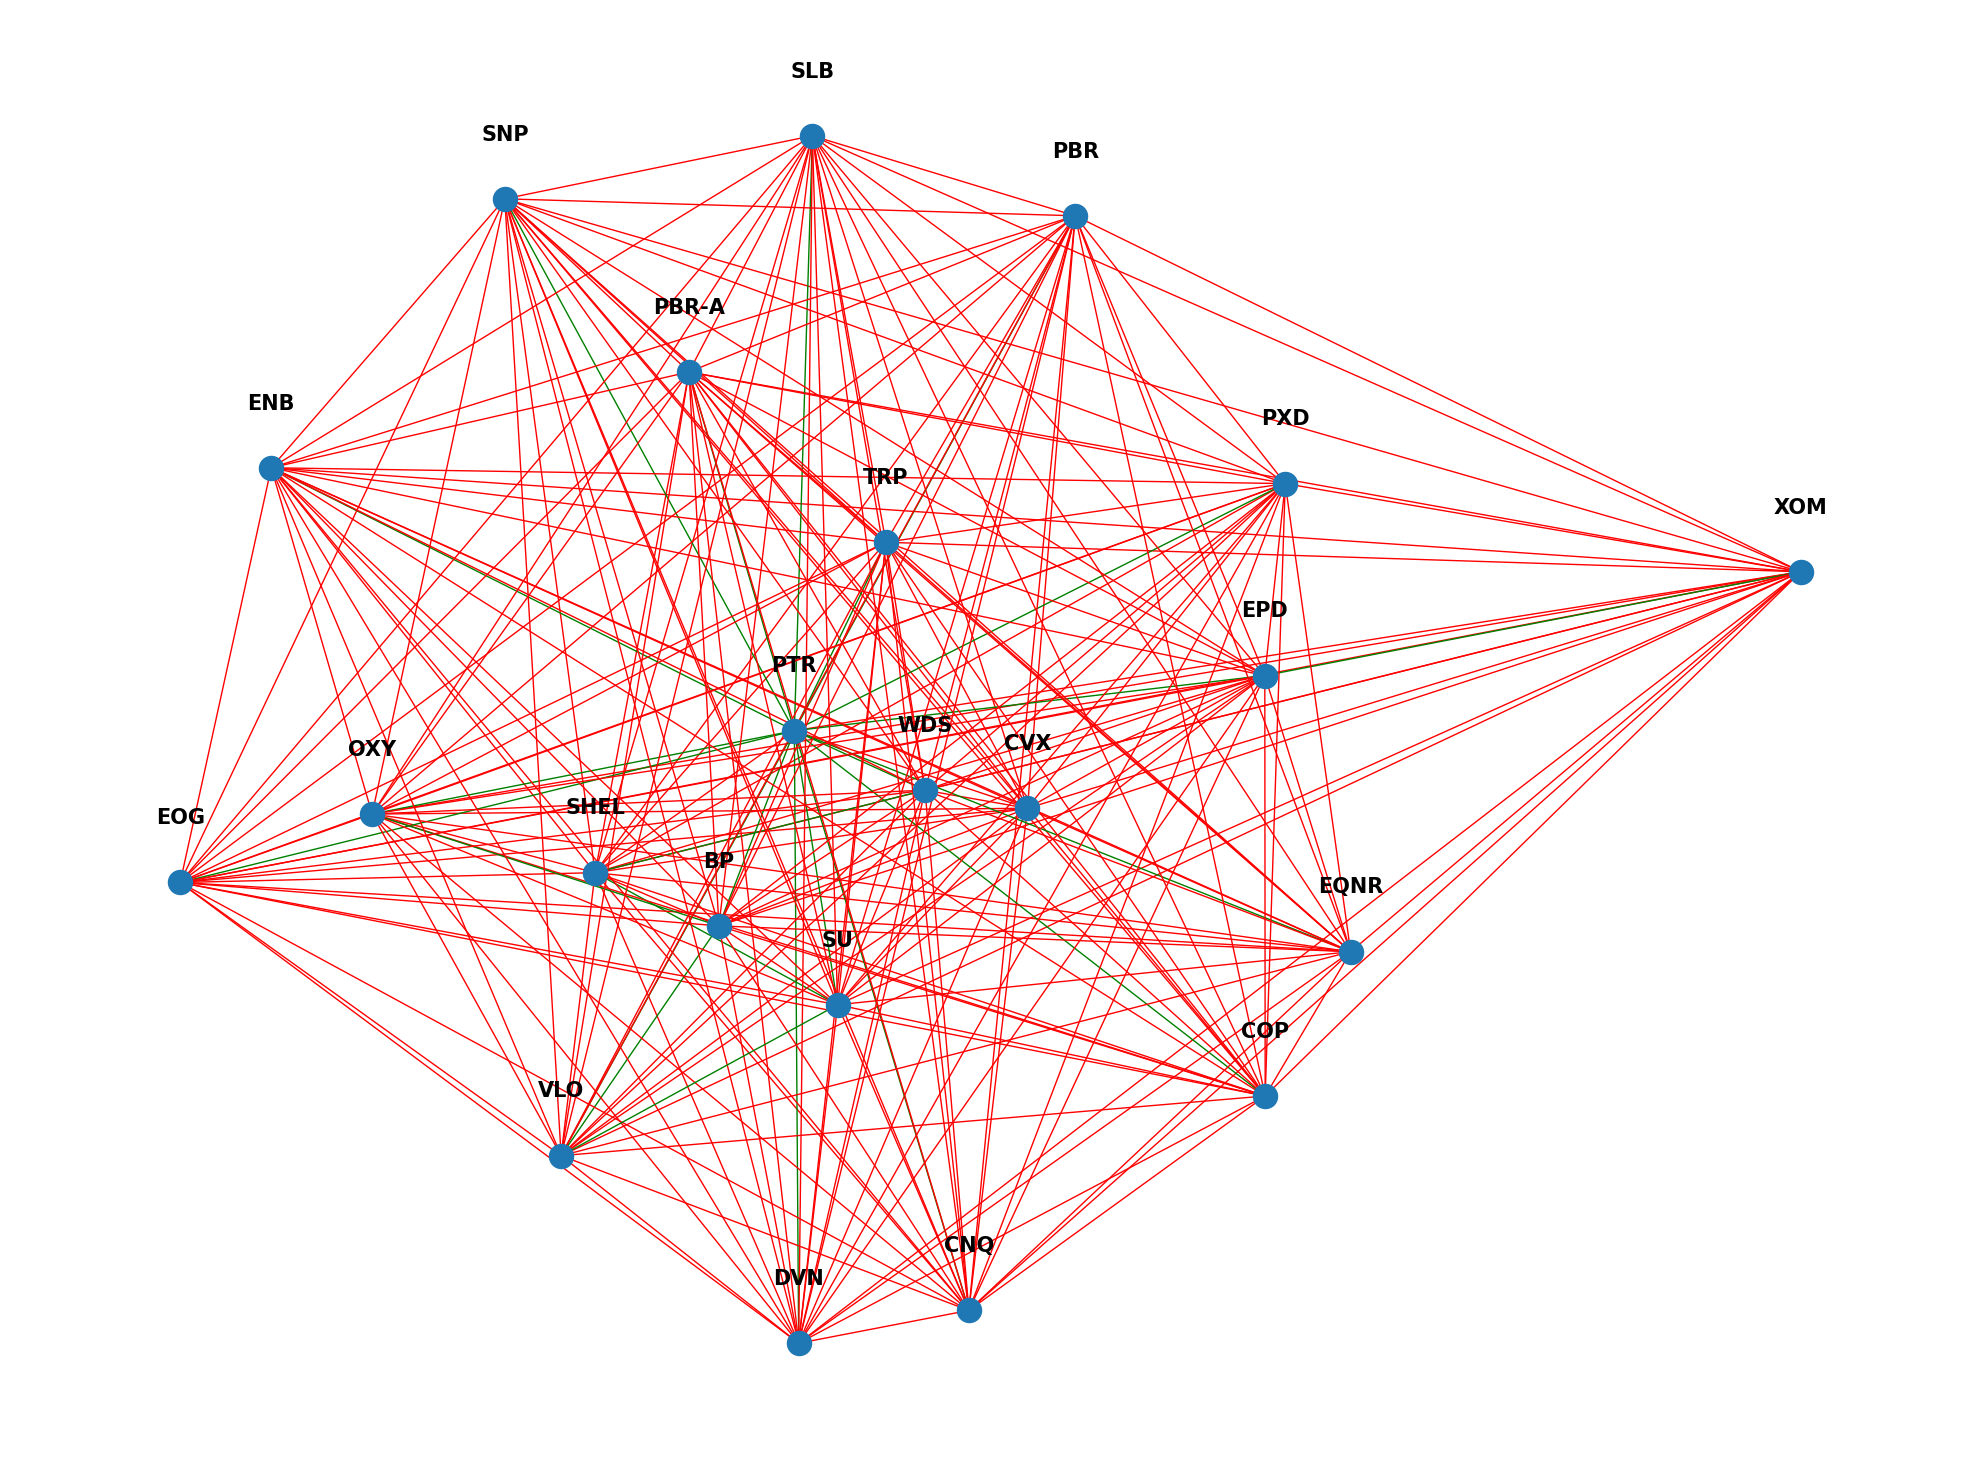

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

data= coint_tickers2

G = nx.Graph()

for item in data:
    n = len(item[0])
    for i in range(n - 1):
        if item[1] == 0 or item[1] == n:
            color = "red"
        elif item[1] == n - 1:
            color = "green"
        else:
            color = "blue"
        G.add_edge(item[0][i].upper(), item[0][i + 1].upper(), weight=item[1], color=color)

pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(20, 15))

# Draw nodes
nx.draw_networkx_nodes(G, pos)

# Draw node labels
labels_pos = {k: [v[0], v[1] + 0.07] for k, v in pos.items()}  # Shift labels up by 0.1 units
nx.draw_networkx_labels(G, labels_pos, font_size=15, font_weight="bold")

# Draw edges
edges = G.edges(data=True)
colors = [d["color"] for _, _, d in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors)

plt.axis("off")
plt.tight_layout()
plt.savefig("coint network firms 350", dpi=350)


# 3. Estimate the Volatility Models

In [ ]:
! pip install arch

In [ ]:
brentrt = brent.pct_change().dropna()
wtirt = wti.pct_change().dropna()
murbanrt = murban.pct_change().dropna()
uralsrt = urals.pct_change().dropna()

In [ ]:
from arch import arch_model
results = []
results_garch = []

for p in range(1,21):
  for q in range(1,21):
    am = arch_model(brentrt, p=p, q=q)
    res = am.fit(disp=False)
    results_garch.append([p, res.bic])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


brentrt_train = brentrt.iloc[:int(len(brentrt) * 0.9)]
brentrt_test = brentrt.iloc[int(len(brentrt) * 0.9):]

am = arch_model(brentrt_train, p=9, q=0)
res = am.fit(disp=False)

forecasts = []
for t in range(len(brentrt_test)):
    updated_train = brentrt.iloc[:int(len(brentrt) * 0.9) + t]
    am_updated = arch_model(updated_train, p=3, q=5)
    res_updated = am_updated.fit(disp=False, last_obs=updated_train.index[-1])
    forecast = res_updated.forecast(horizon=1).variance.iloc[-1, 0]
    forecasts.append(forecast)

# Calculate mean squared error
mse = np.mean((brentrt_test.to_numpy()**2 - forecasts) ** 2)
print("Mean squared error:", mse)

# Plot the true variance and estimated variance
plt.plot(brentrt_test.index, brentrt_test ** 2, label="True variance")
plt.plot(brentrt_test.index, forecasts, label="Estimated variance", linestyle="--")
plt.legend()
plt.show()


In [ ]:
forecasts_arch = forecasts

Text(0.5, 0, 'Time')

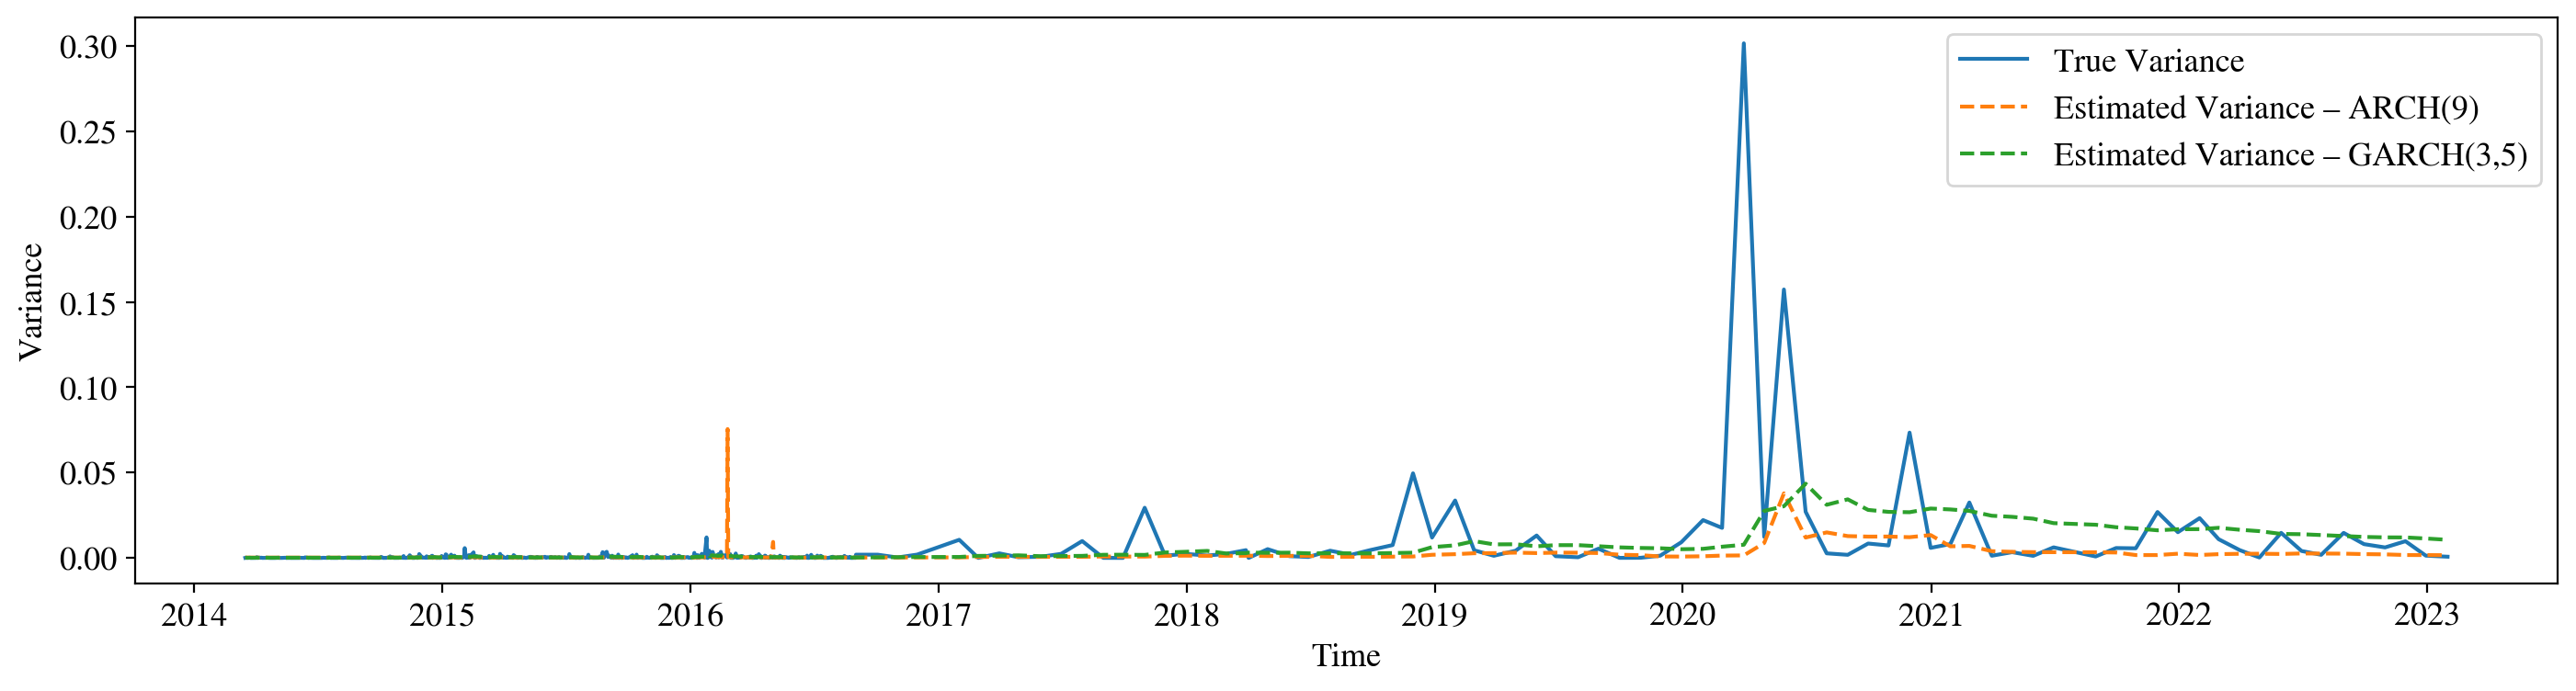

In [ ]:
plt.figure(figsize=(17,4), dpi=200)
plt.plot(brentrt_test.index, brentrt_test ** 2, label="True Variance")
plt.plot(brentrt_test.index, forecasts_arch, label="Estimated Variance – ARCH(9)", linestyle="--")
plt.plot(brentrt_test.index, forecasts, label="Estimated Variance – GARCH(3,5)", linestyle="--")
plt.legend()
plt.ylabel("Variance")
plt.xlabel("Time")

In [ ]:
plt.savefig("ARCH", dpi=300)

<Figure size 640x480 with 0 Axes>

In [ ]:
brentrt_2 = brentrt[brentrt.index < date(2022, 2, 1)]
wtirt_2 = wtirt[wtirt.index > date(2022, 2, 1)]
murbanrt_2 = murbanrt[murbanrt.index > date(2022, 2, 1)]
uralsrt_2 = uralsrt[uralsrt.index > date(2022, 2, 1)]
brentrt

In [ ]:
import numpy as np
import scipy.stats as st
from arch import arch_model

# Estimate the ARCH(9) model
am = arch_model(uralsrt, p=9, q=0)
res = am.fit(disp=False)

# Calculate the standardized residuals
standardized_resid = res.resid / res.conditional_volatility

# Calculate the kurtosis of the standardized residuals
kurt = st.kurtosis(standardized_resid)

# Calculate the conditional variance
conditional_variance = res.conditional_volatility**2

# Calculate the fourth moment of the conditional variances
fourth_moment = np.mean(conditional_variance**2)

# Multiply the kurtosis by the fourth moment of the conditional variances
fourth_moment_total = kurt * fourth_moment

print("Fourth moment:", fourth_moment_total)


/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008199. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Fourth moment: 2.7952716529383505e-06


In [ ]:
import numpy as np
import scipy.stats as st
from arch import arch_model

# Estimate the ARCH(9) model
am = arch_model(uralsrt, p=9, q=0)
res = am.fit(disp=False)

# Calculate the standardized residuals
standardized_resid = res.resid / res.conditional_volatility

# Calculate the skewness of the standardized residuals
skew = st.skew(standardized_resid)

# Calculate the conditional variance
conditional_variance = res.conditional_volatility**2

# Calculate the third moment of the conditional variances
third_moment = np.mean(conditional_variance**1.5)

# Multiply the skewness by the third moment of the conditional variances
third_moment_total = skew * third_moment

print("Third moment:", third_moment_total)


/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008199. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Third moment: -1.4171276274063578e-06


In [ ]:
import numpy as np
import scipy.stats as st
from arch import arch_model

# Estimate the ARCH(9) model
am = arch_model(uralsrt, p=9, q=0)
res = am.fit(disp=False)

# Calculate the standardized residuals
standardized_resid = res.resid / res.conditional_volatility

# Calculate the variance of the standardized residuals
variance_standardized_resid = np.var(standardized_resid)

# Calculate the conditional variance
conditional_variance = res.conditional_volatility**2

# Calculate the second moment of the conditional variances
second_moment = np.mean(conditional_variance)

# Since the standardized residuals have unit variance, the variance of the process
# is simply the second moment of the conditional variances.
variance_total = second_moment

print("Variance:", variance_total)


/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008199. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Variance: 0.0005860874914861642


In [ ]:
0.042247**2, 0.022331**2, 0.022560**2,  0.028636**2

(0.001784809009, 0.000498673561, 0.0005089536, 0.000820020496)

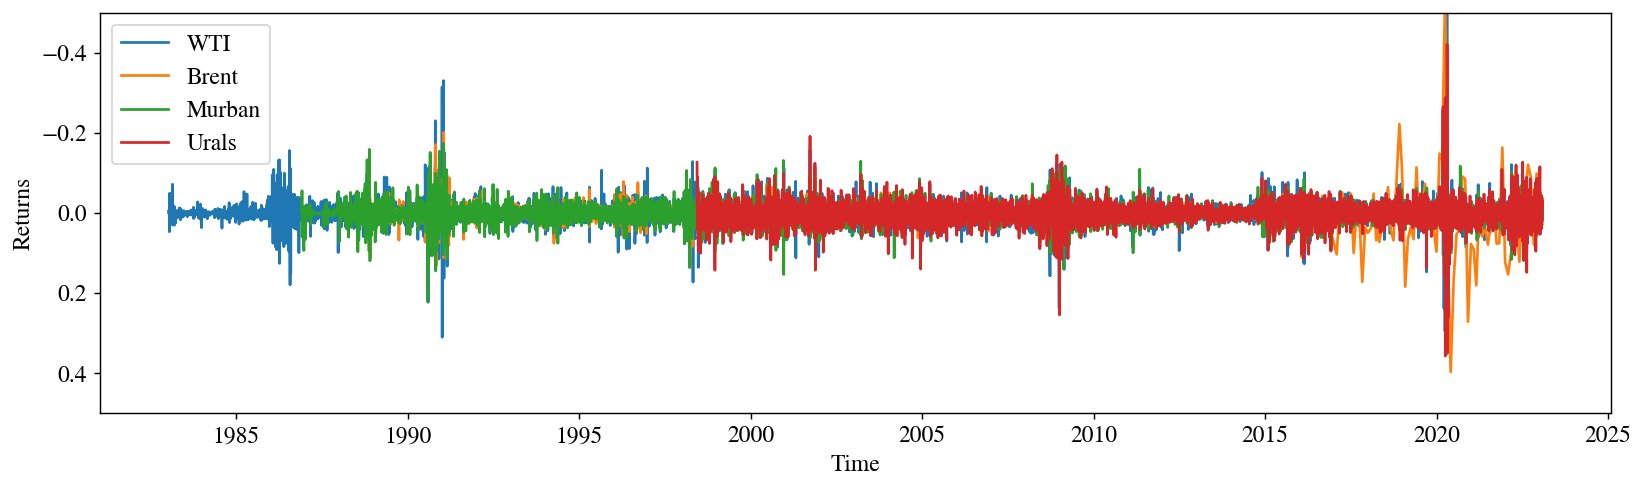

In [ ]:
plt.figure(figsize=(15,4), dpi=130)
plt.plot(wti.pct_change(), label="WTI")
plt.plot(brent.pct_change(), label="Brent")
plt.plot(murban.pct_change(), label="Murban")
plt.plot(urals.pct_change(), label="Urals")
plt.ylim(0.5,-0.5)
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend()
plt.savefig("returns_ts", dpi=300)